In [1]:
# reading pz file into dict_station

import os
import obspy
from obspy.io.sac.sacpz import attach_paz
from obspy import read, Stream, UTCDateTime, Trace

dict_station = {}
#dict_station
PZs = os.listdir('PZs')
#print(PZs)
for pzfile in PZs :
    #print(pzfile)
    station_name = pzfile.split('_')[3]
    if (station_name in dict_station ):
        continue
        
    tr = Trace()
    attach_paz(tr, 'PZs/'+pzfile)
    #print(station_name)
    
    dict_station[station_name] = tr

In [2]:
import numpy as np
from obspy import read, Stream, UTCDateTime, Trace

data = np.genfromtxt('events_lat_lon_dep', dtype=str, encoding='utf-8')
day, time  = data[:,1], data[:,2]
lat, lon, dep = data[:,3].astype(float), data[:,4].astype(float),data[:,5].astype(float)


In [3]:
print(day,time)

['2018-08-30' '2019-03-12' '2019-04-01' '2019-05-08' '2019-06-29'
 '2019-10-23' '2019-11-11' '2019-11-11' '2020-04-10' '2020-07-12'
 '2020-07-12' '2020-08-26' '2020-09-30' '2020-10-19' '2020-11-03'
 '2020-12-19' '2021-01-25' '2018-10-29' '2018-11-20' '2019-04-05'
 '2019-04-27' '2019-07-27' '2019-08-15'] ['20:14:24.150' '20:19:15.390' '02:54:35.620' '15:48:47.350'
 '16:20:06.100' '20:15:58.160' '16:54:57.780' '18:11:33.40' '16:44:57.450'
 '04:06:08.610' '09:29:24.550' '22:15:08.600' '04:37:20.330'
 '06:06:26.810' '17:59:06.20' '13:42:39.70' '11:39:23.760' '01:27:44.30'
 '19:09:48.80' '09:56:52.70' '17:24:45.70' '18:31:7.50' '05:32:53.10']


In [4]:
"""

f = open('new_event_format.txt','w')
for i in range(len(day)) :#
    starttime = UTCDateTime(day[i]+time[i])
    dir_name = starttime.strftime('%Y%m%d_%H%M%S')
    sac_form = starttime.strftime('%Y %j %H %M %S')
    ms = int(starttime.microsecond/1000)
    #print(dir_name, time[i])
    #print(sac_form ,ms)
    f.write('%s %s\n'%(dir_name, sac_form))
f.close()
"""

"\n\nf = open('new_event_format.txt','w')\nfor i in range(len(day)) :#\n    starttime = UTCDateTime(day[i]+time[i])\n    dir_name = starttime.strftime('%Y%m%d_%H%M%S')\n    sac_form = starttime.strftime('%Y %j %H %M %S')\n    ms = int(starttime.microsecond/1000)\n    #print(dir_name, time[i])\n    #print(sac_form ,ms)\n    f.write('%s %s\n'%(dir_name, sac_form))\nf.close()\n"

In [6]:
# Reading and preprocessing the Formosa Array Data 
from obspy.io.sac import SACTrace
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees, degrees2kilometers
import glob
import os
from obspy.geodetics.base import gps2dist_azimuth
from obspy.io.sac.sacpz import attach_paz


st_all = Stream()

model = TauPyModel(model='prem')
#for i in range(len(day)):
for i in np.arange(18):
    starttime = UTCDateTime(day[i]+time[i])
    dir = starttime.strftime('%Y%m%d_%H%M%S')
    
    print(dir, starttime)
    #sac_bh = glob.glob('%s/*VO01..BHZ.SAC'%(dir))
    sac_bh = glob.glob('%s/*BHZ.SAC'%(dir))
    
    os.mkdir('p/%s'%(dir))
    os.mkdir('s/%s'%(dir))
    
    for sacfile in sac_bh:
        st_ori = Stream()
        sta = sacfile.split('.')[1]
        if (sta == 'CT15' or sta=='WU18'):
            continue
        
        st = read('%s/*%s*BH*.SAC'%(dir,sta))
        #print(st)
        st.trim(starttime=starttime-250, endtime=starttime+250)
        
        epi_dis = locations2degrees(lat[i],lon[i],
                                    st[0].stats.sac.stla, st[0].stats.sac.stlo)
        dis_m , az, baz = gps2dist_azimuth(lat[i],lon[i],
                                           st[0].stats.sac.stla, st[0].stats.sac.stlo)
        #print(dis_m , az, baz)
        paz_sts2 = {'poles': dict_station[sta].stats.paz['poles'],
                    'zeros': dict_station[sta].stats.paz['zeros'], 
                    'gain': dict_station[sta].stats.paz['gain'],
                    'sensitivity' : dict_station[sta].stats.paz['sensitivity'] }
#                    'sensitivity':3e+8}
        st.simulate(paz_remove=paz_sts2)
        st.filter('bandpass', freqmax=3, freqmin=0.05, corners=2, zerophase = True)       
        st.rotate(method='NE->RT', back_azimuth=baz)        
        #st.detrend(type='demean')
        st.trim(starttime=starttime, endtime=starttime+120)
        st_ori += st.copy()
        
        #st.plot()
        for tr in st :
            #print(tr)
            #tr.plot()
            sac = SACTrace.from_obspy_trace(tr)
            # modify loop
            epi_dis = locations2degrees(sac.stla, sac.stlo, lat[i],lon[i])
            arr_time = model.get_travel_times(source_depth_in_km=dep[i],
                                              distance_in_degree=epi_dis,
                                              phase_list=['p','s'])
            tr.stats.sac.az = az
            tr.stats.distance = dis_m
            st_all += tr
            sac.evla = lat[i]
            sac.evlo = lon[i]
            sac.evdp = dep[i]
            sac.stdp = 0.
            sac.stel = 0.
            sac.o = starttime
            sac.iztype = 'io' 
            sac.lcalda = True 
            
            for phase in ['p', 's']:
                if (phase == 'p'):
                    sac.t0 = arr_time[0].time
                    sac.t2 = arr_time[0].time
                    sac.kt0 = arr_time[0].name
                elif (phase == 's') :
                    sac.t0 = arr_time[1].time
                    sac.t2 = arr_time[1].time
                    sac.kt0 = arr_time[1].name
                name = ('%s/%s.%s.%s.SAC')%(dir, tr.stats.network, tr.stats.station, tr.stats.channel)
                sac.write('%s/%s.mark'%(phase, name))
                
           
            #sac.write('p/%s.%s.%s.mark'%(tr.stats.network,tr.stats.station,tr.stats.channel))
    print('ok')
    #os.chdir('../')


20190312_201915 2019-03-12T20:19:15.390000Z


/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


SacIOError: Cannot open file: Processed_20190312/20190312_201915/FM.KM06.BHT.SAC.mark

In [6]:
st_cwb = read('20190312_201915_BATS/*mark')

#st_cwb.select(station='ANP')[0].stats.distance
#st_cwb.select(station='ANP')[0].stats.sac.dist
for tr in st_cwb:
    tr.stats.distance = tr.stats.sac.dist *1000.
st_all += st_cwb.copy()

In [5]:
# Reading and preprocessing the Formosa Array Data
# plot spectrum
from obspy.io.sac import SACTrace
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees, degrees2kilometers
import glob
import os
from obspy.geodetics.base import gps2dist_azimuth
from obspy.io.sac.sacpz import attach_paz


st_all = Stream()

model = TauPyModel(model='prem')
#for i in range(len(day)):
for i in np.arange(18):
    starttime = UTCDateTime(day[i]+time[i])
    dir = starttime.strftime('%Y%m%d_%H%M%S')
    
    print(dir, starttime)
    #sac_bh = glob.glob('%s/*VO01..BHZ.SAC'%(dir))
    sac_bh = glob.glob('%s/*BHZ.SAC'%(dir))
    
    os.mkdir('p/%s'%(dir))
    os.mkdir('s/%s'%(dir))
    
    for sacfile in sac_bh:
        st_ori = Stream()
        sta = sacfile.split('.')[1]
        if (sta == 'CT15' or sta=='WU18'):
            continue
        
        st = read('%s/*%s*BH*.SAC'%(dir,sta))
        #print(st)
        st.trim(starttime=starttime-250, endtime=starttime+250)
        
        epi_dis = locations2degrees(lat[i],lon[i],
                                    st[0].stats.sac.stla, st[0].stats.sac.stlo)
        dis_m , az, baz = gps2dist_azimuth(lat[i],lon[i],
                                           st[0].stats.sac.stla, st[0].stats.sac.stlo)
        #print(dis_m , az, baz)
        paz_sts2 = {'poles': dict_station[sta].stats.paz['poles'],
                    'zeros': dict_station[sta].stats.paz['zeros'], 
                    'gain': dict_station[sta].stats.paz['gain'],
                    'sensitivity' : dict_station[sta].stats.paz['sensitivity'] }
#                    'sensitivity':3e+8}
        st.simulate(paz_remove=paz_sts2)
        st.filter('bandpass', freqmax=3, freqmin=0.05, corners=2, zerophase = True)       
        st.rotate(method='NE->RT', back_azimuth=baz)        
        #st.detrend(type='demean')
        st.trim(starttime=starttime, endtime=starttime+120)
        st_ori += st.copy()
        
        #st.plot()
        for tr in st :
            #print(tr)
            #tr.plot()
            sac = SACTrace.from_obspy_trace(tr)
            # modify loop
            epi_dis = locations2degrees(sac.stla, sac.stlo, lat[i],lon[i])
            arr_time = model.get_travel_times(source_depth_in_km=dep[i],
                                              distance_in_degree=epi_dis,
                                              phase_list=['p','s'])
            tr.stats.sac.az = az
            tr.stats.distance = dis_m
            st_all += tr
            sac.evla = lat[i]
            sac.evlo = lon[i]
            sac.evdp = dep[i]
            sac.stdp = 0.
            sac.stel = 0.
            sac.o = starttime
            sac.iztype = 'io' 
            sac.lcalda = True 
            
            for phase in ['p', 's']:
                if (phase == 'p'):
                    sac.t0 = arr_time[0].time
                    sac.t2 = arr_time[0].time
                    sac.kt0 = arr_time[0].name
                elif (phase == 's') :
                    sac.t0 = arr_time[1].time
                    sac.t2 = arr_time[1].time
                    sac.kt0 = arr_time[1].name
                name = ('%s/%s.%s.%s.SAC')%(dir, tr.stats.network, tr.stats.station, tr.stats.channel)
                #sac.write('%s/%s.mark'%(phase, name))
           
            #sac.write('p/%s.%s.%s.mark'%(tr.stats.network,tr.stats.station,tr.stats.channel))
    print('ok')
    #os.chdir('../')


20180830_201424 2018-08-30T20:14:24.150000Z


/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


ok
20190312_201915 2019-03-12T20:19:15.390000Z
ok
20190401_025435 2019-04-01T02:54:35.620000Z
ok
20190508_154847 2019-05-08T15:48:47.350000Z
ok
20190629_162006 2019-06-29T16:20:06.100000Z
ok
20191023_201558 2019-10-23T20:15:58.160000Z
ok
20191111_165457 2019-11-11T16:54:57.780000Z
ok
20191111_181133 2019-11-11T18:11:33.400000Z
ok
20200410_164457 2020-04-10T16:44:57.450000Z
ok
20200712_040608 2020-07-12T04:06:08.610000Z
ok
20200712_092924 2020-07-12T09:29:24.550000Z
ok
20200826_221508 2020-08-26T22:15:08.600000Z
ok
20200930_043720 2020-09-30T04:37:20.330000Z
ok
20201019_060626 2020-10-19T06:06:26.810000Z
ok
20201103_175906 2020-11-03T17:59:06.200000Z
ok
20201219_134239 2020-12-19T13:42:39.700000Z
ok
20210125_113923 2021-01-25T11:39:23.760000Z
ok
20181029_012744 2018-10-29T01:27:44.300000Z


IndexError: list index out of range

20.0


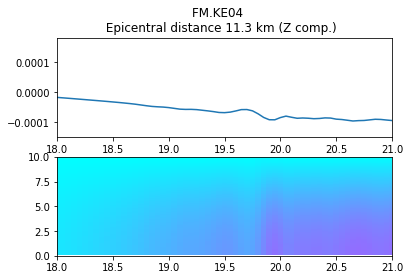

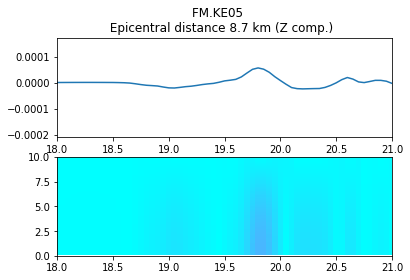

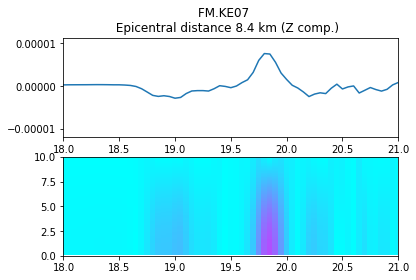

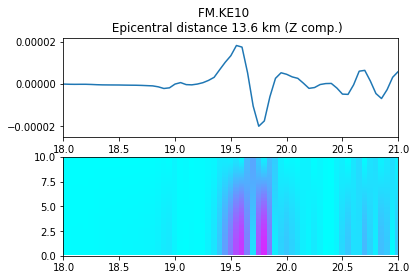

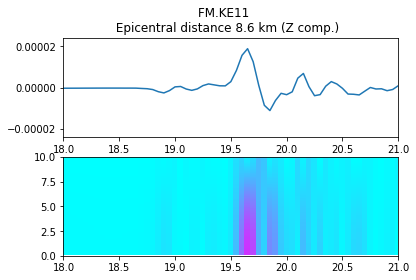

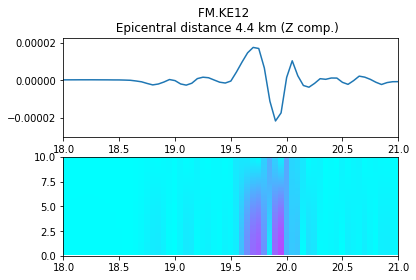

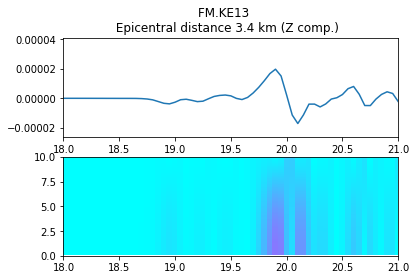

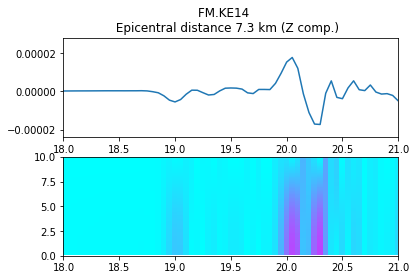

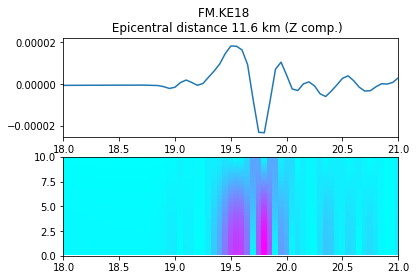

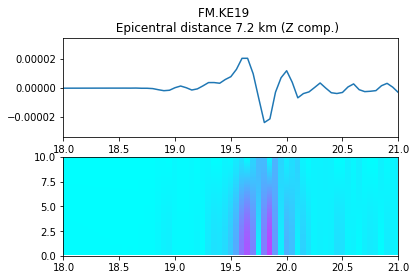

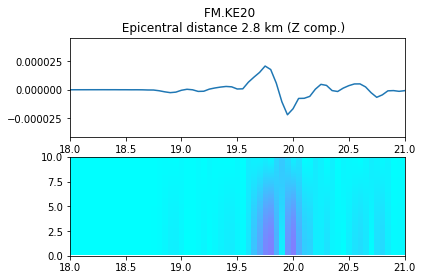

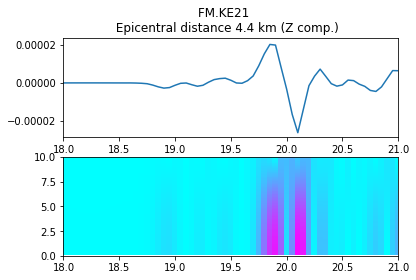

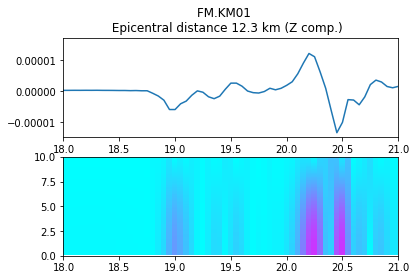

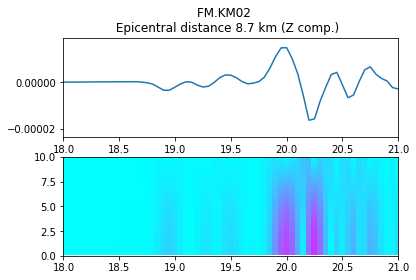

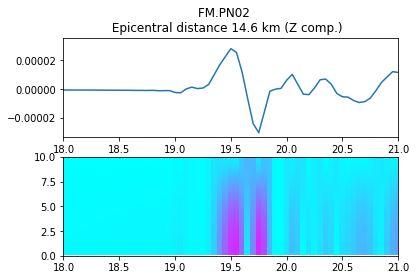

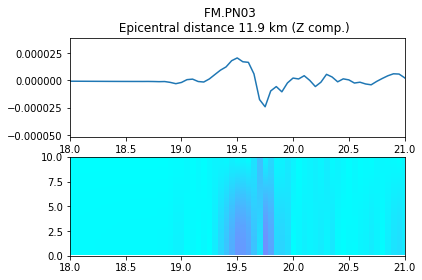

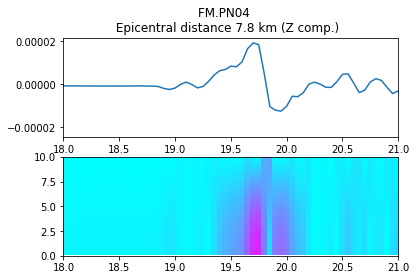

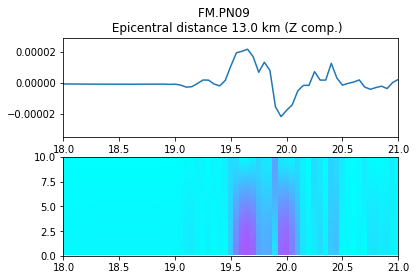

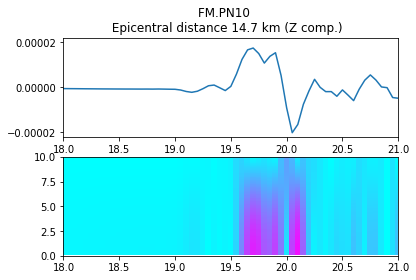

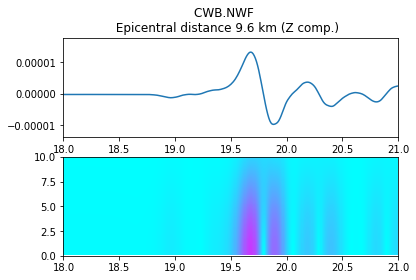

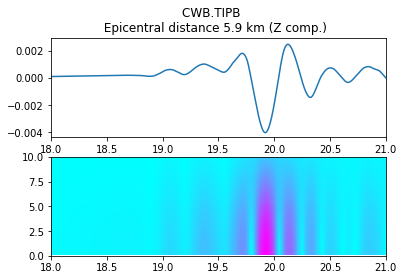

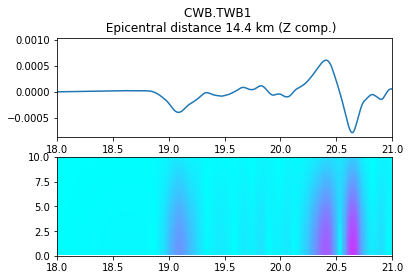

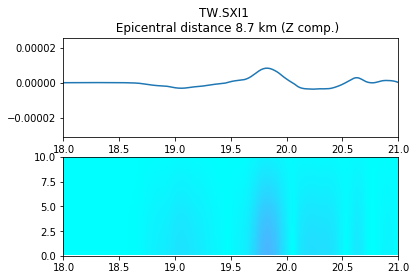

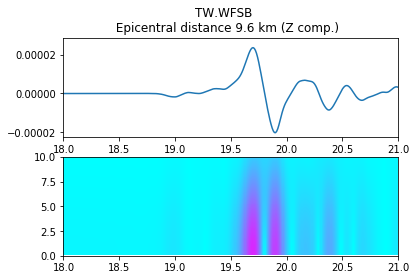

In [7]:

import matplotlib.pyplot as plt

st_near = Stream()
for tr in st_all.select(component='Z'):
    if tr.stats.distance > 15*1000. :
        continue
    st_near += tr.copy()

st_near.trim(starttime=starttime, endtime=starttime+60)
print(st_near[0].stats.sampling_rate)

def plot_seis_specto(tr):
    fig=plt.figure()
    
    plt.subplot(211)
    plt.plot(tr.times(),tr.data)
    plt.xlim(18,21)
    
    ax2=plt.subplot(212)
    tr.spectrogram(axes=ax2,cmap='cool',per_lap=0.95 ,wlen=0.2, mult=50.)
    plt.xlim(18,21)
    plt.ylim(0,10)

    plt.suptitle('%s.%s \n Epicentral distance %.1f km (%s comp.)'%(tr.stats.network,
                tr.stats.station,tr.stats.distance/1000.,tr.stats.component),y=0.99)
    plt.savefig('%.1f_%s_seim_spectro.png'%(tr.stats.distance/1000., tr.stats.station))
    plt.show()
    plt.close()
    

for tr in st_near:
    plot_seis_specto(tr)

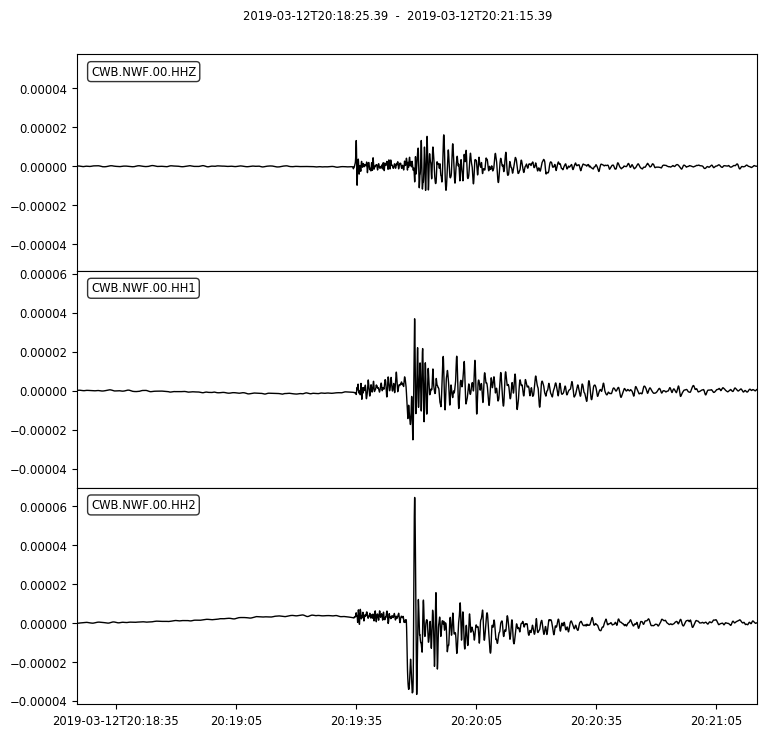

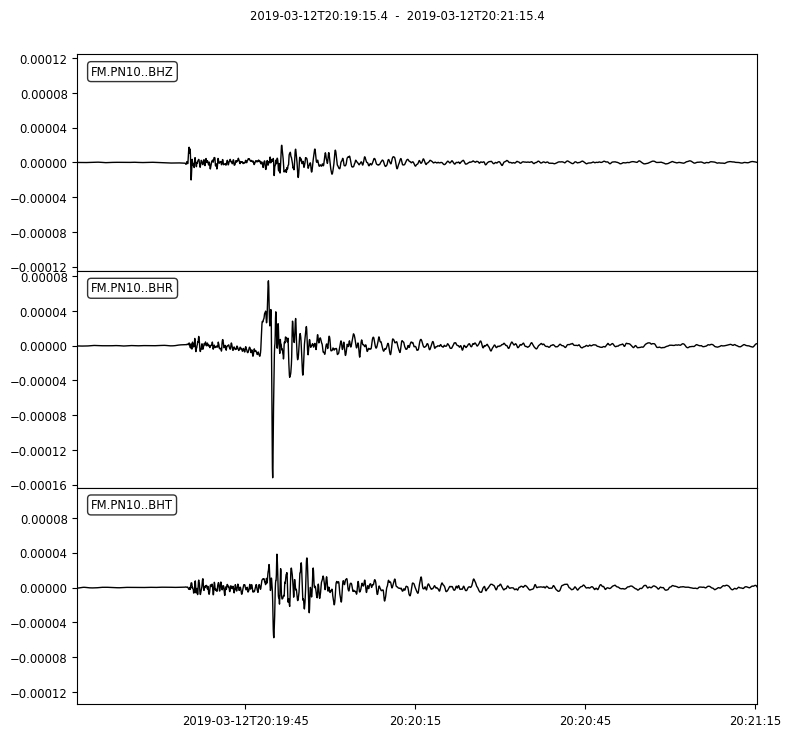

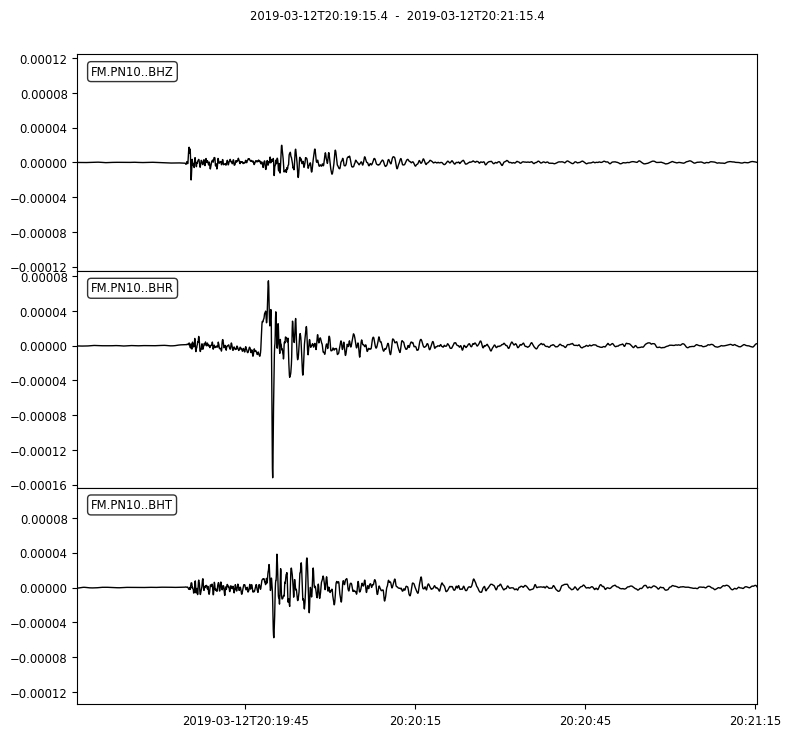

In [8]:
st_test = Stream()
st_all.select(station='NWF').plot()
st_all.select(station='PN10').plot()


20.0
[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


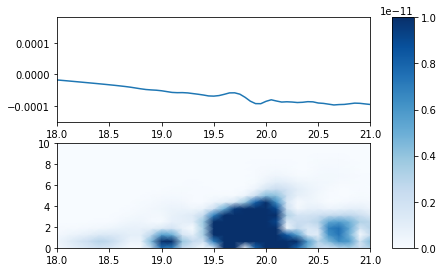

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


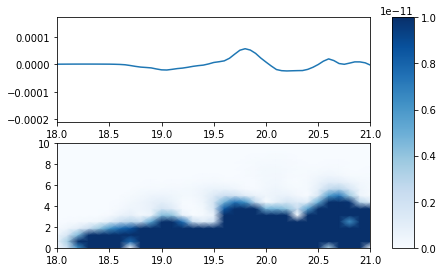

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


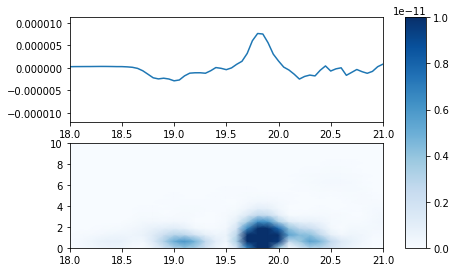

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


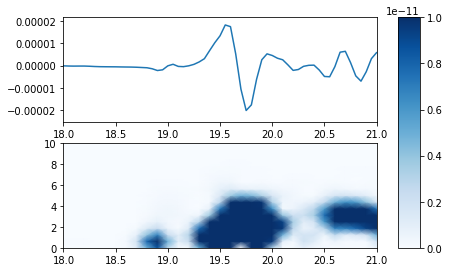

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


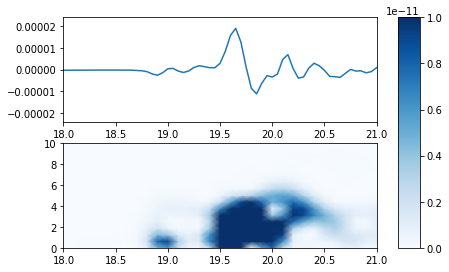

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


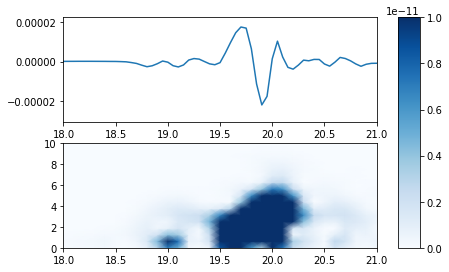

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


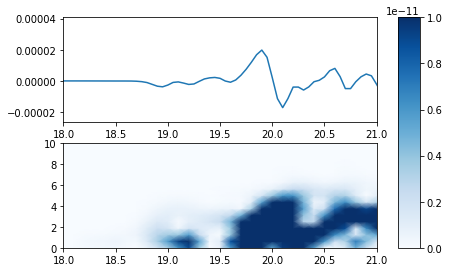

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


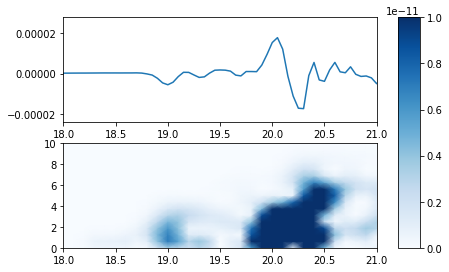

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


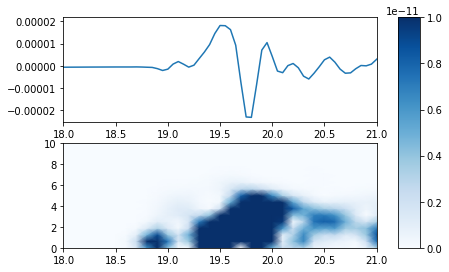

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


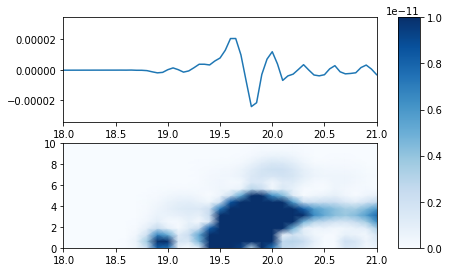

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


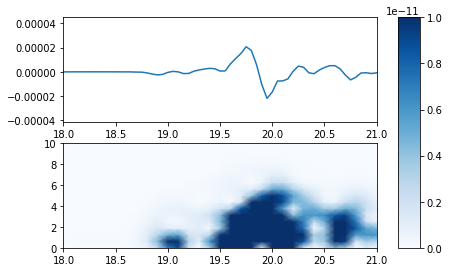

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


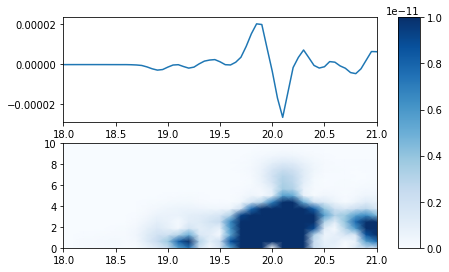

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


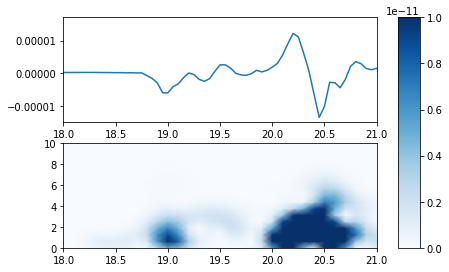

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


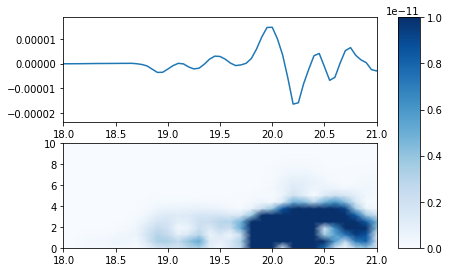

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


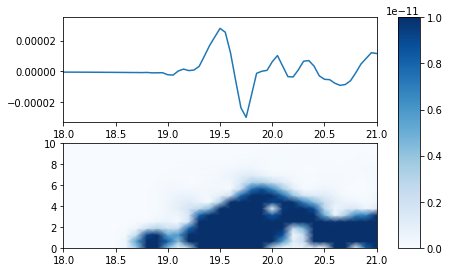

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


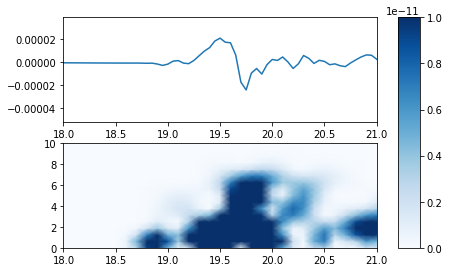

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


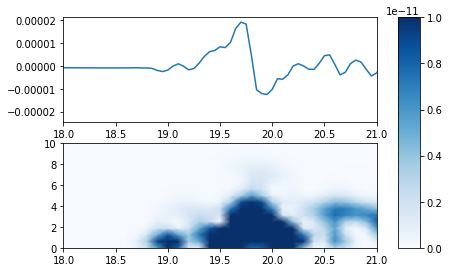

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


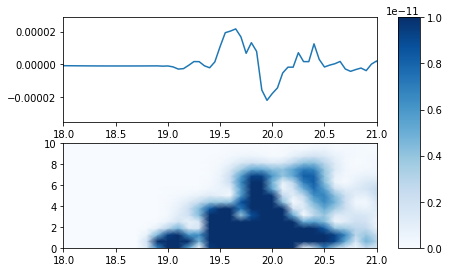

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


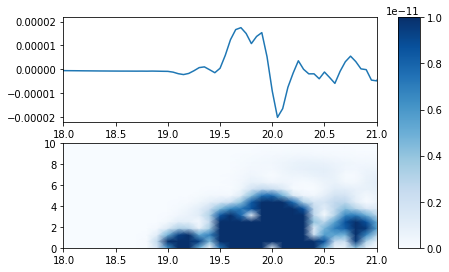

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


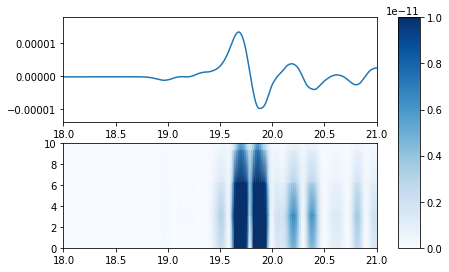

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


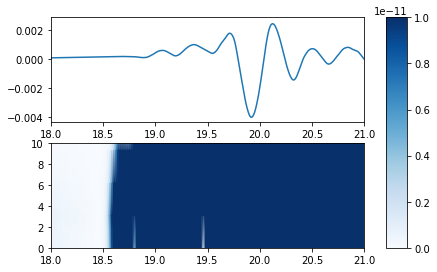

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


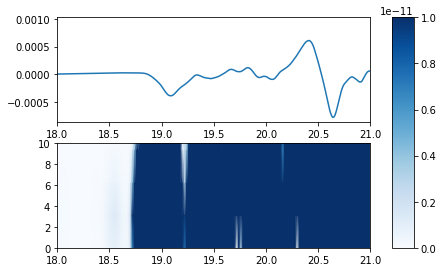

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


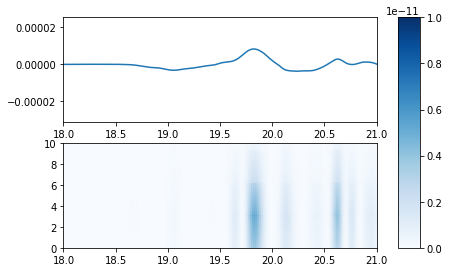

[  1.59725788e-06   8.45666597e-06   4.00652974e-05   1.69856677e-04
   6.44379821e-04   2.18749112e-03   6.64501128e-03   1.80630134e-02
   4.39369336e-02   9.56344448e-02   1.86270464e-01   3.24652467e-01
   5.06335617e-01   7.06648278e-01   8.82496903e-01   9.86207117e-01
   9.86207117e-01   8.82496903e-01   7.06648278e-01   5.06335617e-01
   3.24652467e-01   1.86270464e-01   9.56344448e-02   4.39369336e-02
   1.80630134e-02   6.64501128e-03   2.18749112e-03   6.44379821e-04
   1.69856677e-04   4.00652974e-05   8.45666597e-06   1.59725788e-06]


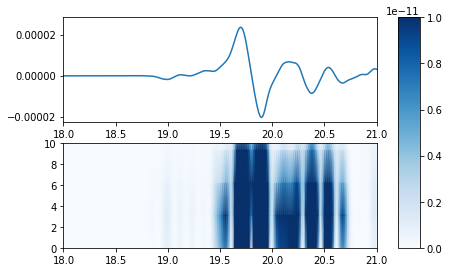

In [8]:
# plot spectrogram and waveform of epidistance < 15 km
import matplotlib.pyplot as plt
from scipy import signal

st_near = Stream()
for tr in st_all.select(component='Z'):
    if tr.stats.distance > 15*1000. :
        continue
    st_near += tr.copy()

st_near.trim(starttime=starttime, endtime=starttime+60)
print(st_near[0].stats.sampling_rate)

def plot_seis_specto(tr):
    fig=plt.figure()
    
    plt.subplot(211)
    plt.plot(tr.times(),tr.data)
    plt.xlim(18,21)
    
    ax2=plt.subplot(212)
    #win=signal.get_window('hamming',10)
    win= signal.windows.general_gaussian(32, p=1, sig=3)
    print(win)
    ff, tt, Sxx = signal.spectrogram(tr.data, fs=tr.stats.sampling_rate,
                                     window=win, nperseg=32,noverlap=30,
                                     scaling='spectrum',detrend ='linear')
    #print(tt)
    plt.xlim(18,21)
    plt.ylim(0,10)
    plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
    
    plt.pcolormesh(tt,ff,Sxx ,shading='gouraud',cmap='Blues',vmax=1e-11)
    cax= plt.axes([0.9,0.1,0.05,0.8])
    plt.colorbar(cax=cax)
    plt.savefig('%.1f_%s_seim_spectro.png'%(tr.stats.distance/1000., tr.stats.station))
    plt.show()
    plt.close()

for tr in st_near:
    plot_seis_specto(tr)

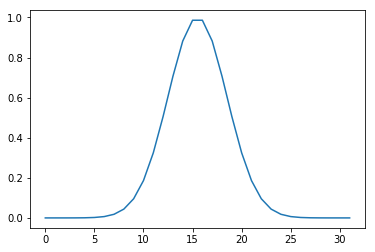

In [138]:

win= signal.windows.general_gaussian(32, p=1, sig=3)
#print(win)

plt.plot(win)
plt.show()

In [45]:
# map of the waveform
import matplotlib.pyplot as plt
sta_lat = []
sta_lon = []
sta_epi = []
sta_name =[]
sta_az = []
st_near = Stream()

for tr in st_all.select(component='Z'):
    if tr.stats.distance > 17*1000. :
        
        continue
    sta_name.append(tr.stats.station)
    sta_lat.append(tr.stats.sac.stla)
    sta_lon.append(tr.stats.sac.stlo)
    sta_epi.append(tr.stats.distance)
    sta_az.append(tr.stats.sac.az)
    st_near += tr.copy()

st_near.trim(starttime=starttime, endtime=starttime+60)
#print(st_near[0].stats.sampling_rate)


27 Trace(s) in Stream:

FM.KE03..BHZ | 2019-03-12T20:19:15.400000Z - 2019-03-12T20:20:15.400000Z | 20.0 Hz, 1201 samples
...
(25 other traces)
...
TW.WFSB..HHZ | 2019-03-12T20:19:15.398393Z - 2019-03-12T20:20:15.398393Z | 100.0 Hz, 6001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

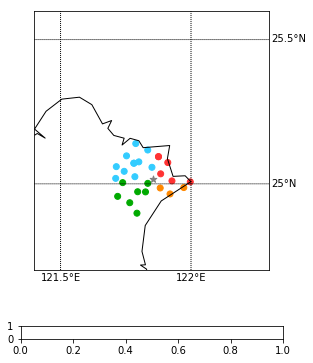

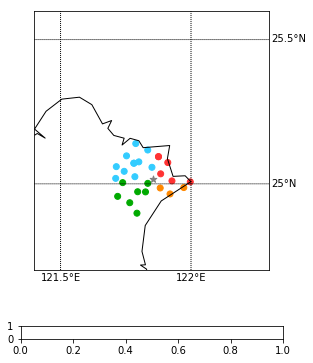

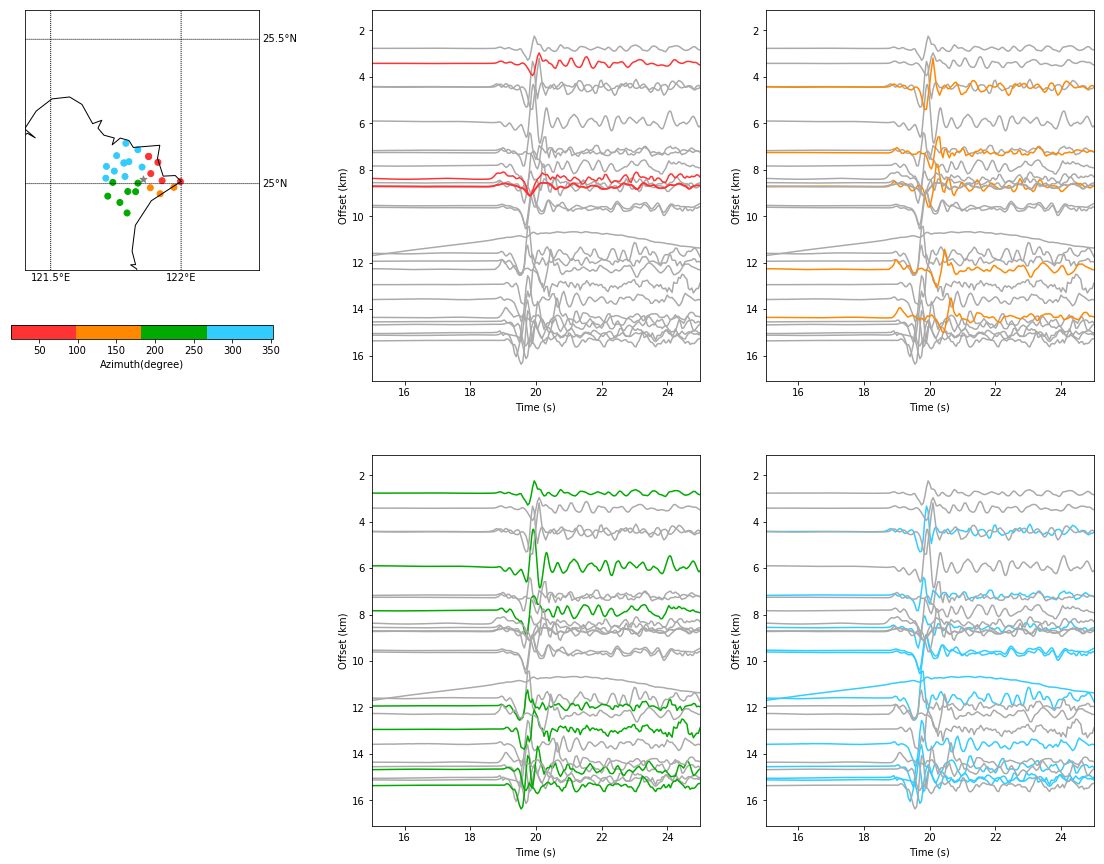

In [50]:
import os
os.environ["PROJ_LIB"] = "D:\\anaconda\\envs\\test\\Library\\share\\basemap"
##"D:\\anaconda\\library\\share"; #fixr

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.colors as col
cpool = ['#FF3333','#FF8800','#00AA00','#33CCFF']
cmap3 = col.ListedColormap(cpool[0:4], 'indexed')

fig = plt.figure(figsize=(20,15))

plt.subplot(231)
map = Basemap(projection='merc', llcrnrlat=24.7,urcrnrlat=25.6,
              llcrnrlon=121.4,urcrnrlon=122.3,resolution='i')
parallels = np.arange(10.,30,0.5)
meridians = np.arange(115.,124,0.5)
map.drawparallels(parallels, labels=[False,True,True,False])
map.drawmeridians(meridians, labels=[True,False,False,True])
map.drawcoastlines()
x,y=map(sta_lon,sta_lat)
ex,ey=map(lon[1],lat[1])
sc = map.scatter(x,y,c=sta_az,cmap=cmap3) #cmap='jet_r')
map.scatter(ex,ey,marker='*',color='grey',s=50)
cbar=plt.colorbar(sc,orientation="horizontal",shrink=0.8)
cbar.set_label('Azimuth(degree)')
#
index = sorted(range(len(sta_az)),key = lambda k : sta_az[k],reverse=True)
def plot_by_az(azmin,azmax, c_index):
    for i in index:
        tr = Trace()
        #print(sta_name[i])
        tr = st_near.select(station=sta_name[i])[0]
        y_km = tr.stats.distance/1000.
        az=tr.stats.sac.az
        scale = tr.data.max()
        #print(scale)
        if (  az >=azmin and az<=azmax ) :
            cdis=cpool[c_index]
        else:
            cdis='#AAAAAA'
        plt.plot(tr.times(), y_km + tr.data/scale ,color=cdis)
    plt.xlim(15,25)
    plt.gca().invert_yaxis()
    #plt.ylim(-1,60)
    plt.xlabel('Time (s)')
    plt.ylabel('Offset (km)')
    
plt.subplot(232)
plot_by_az(0.,90.,0)
plt.subplot(233)
plot_by_az(90.,180.,1)
plt.subplot(235)
plot_by_az(180.,270.,2)
plt.subplot(236)
plot_by_az(270.,360.,3)
plt.savefig('azs_seismogram.png',bbox_inches='tight',dpi=300)
plt.show()

import matplotlib.pyplot as plt

dict_net ={'FM':'black','CWB':'red','TW':'blue'}
stmp = Stream()
stmp = st_all.select(component="Z")
fmax, fmin = 2, 0.1
stmp.filter('bandpass',freqmax=fmax,freqmin=fmin, corners=2, zerophase = True)


plt.figure(figsize=(10,10))
for tr in stmp :
    y_km = tr.stats.distance/1000.
    #print(tr.stats.station)
    #print(y_km + tr.data*2000)
    
    plt.plot(tr.times(), y_km + tr.data*20000,dict_net[tr.stats.network])
    plt.gca().invert_yaxis()
    plt.xlim(0,60)
    plt.ylim(-1,60)
    plt.xlabel('Time (s)')
    plt.ylabel('Offset (km)')
    
plt.show()

In [63]:
print(sta_az)
print(sta_name)
print(sorted(sta_az))
a = sorted(range(len(sta_az)),key = lambda k : sta_az[k])
for i in a:
    print(sta_name[i])

[348.9776789946194, 13.299253357887812, 41.91936588178645, 310.38640073911756, 319.2374867834703, 353.22546950044097, 56.42142527073598, 96.53578305101585, 284.2203341918072, 276.3020304419068, 230.2787384369979, 143.13223360011835, 106.01822179671471, 132.10676653487926, 270.56664109232054, 262.83311234737556, 230.43376031246595, 224.6614176956147, 205.52640913829134, 308.66141, 210.81358, 94.750961, 13.30782, 308.37537]
['KE04', 'KE05', 'KE07', 'KE10', 'KE11', 'KE12', 'KE13', 'KE14', 'KE18', 'KE19', 'KE20', 'KE21', 'KM01', 'KM02', 'PN02', 'PN03', 'PN04', 'PN09', 'PN10', 'NWF', 'TIPB', 'TWB1', 'SXI1', 'WFSB']
[13.299253357887812, 13.30782, 41.91936588178645, 56.42142527073598, 94.750961, 96.53578305101585, 106.01822179671471, 132.10676653487926, 143.13223360011835, 205.52640913829134, 210.81358, 224.6614176956147, 230.2787384369979, 230.43376031246595, 262.83311234737556, 270.56664109232054, 276.3020304419068, 284.2203341918072, 308.37537, 308.66141, 310.38640073911756, 319.2374867834

In [8]:
st_near = Stream()
sta= []
for tr in st_all.select(network='FM' ,component='Z') :
    #print(tr.stats.station, tr.stats.distance/1000.)
    sta.append((tr.stats.station, tr.stats.distance/1000.))

#print(sta)
sta.sort(key= lambda x : x[1])
#print(sta)
print('CWB station and epicenter distance(km)')
for i in sta:
    print(i[0], '%.1f'%(i[1]))
    

CWB station and epicenter distance(km)
KE20 2.8
KE13 3.4
KE12 4.4
KE21 4.4
KE19 7.2
KE14 7.3
PN04 7.8
KE07 8.4
KE11 8.6
KE05 8.7
KM02 8.7
KE04 11.3
KE18 11.6
PN03 11.9
KM01 12.3
PN09 13.0
KE10 13.6
PN02 14.6
PN10 14.7
KE17 15.0
KE03 15.1
PN08 15.4
PN14 17.7
PN07 18.1
KE09 18.4
KE02 18.8
KM05 18.9
KM06 19.0
PN13 19.3
KEA1 20.5
PN01 20.5
KE16 20.6
KM34 21.9
PN06 22.5
PN12 22.6
KM07 23.1
KE08 23.3
CT05 23.7
KE01 23.9
KM09 24.2
KM08 24.4
KE15 24.8
PN11 25.5
CT09 26.5
CT04 28.1
KM10 28.1
KM11 28.3
VO10 28.4
CT13 28.8
KM12 29.2
VO05 29.5
CT08 30.8
KM13 31.0
VO14 31.6
PN15 32.3
CT03 32.8
KM15 32.9
KM16 33.3
KM17 33.4
VO04 33.7
CT12 33.8
CT16 34.5
VO09 34.8
CT07 35.2
KM18 35.2
VO13 35.6
WU03 36.1
CT15 36.5
CT15 36.5
CT15 36.5
CT15 36.5
KM19 37.0
CT11 37.8
CT02 38.4
WU10 38.5
VO12 39.0
VO03 39.1
VO08 39.1
KM22 39.2
VO01 39.3
WU18 39.4
KM21 39.5
KM23 39.7
CT06 40.0
WU02 40.1
CT10 41.7
KM24 41.8
CT01 42.2
VO07 42.7
CT14 42.9
WU01 43.0
VO02 43.9
LK03 44.1
KM28 44.2
VO11 44.2
KM27 44.3
KM30 44.8
KM

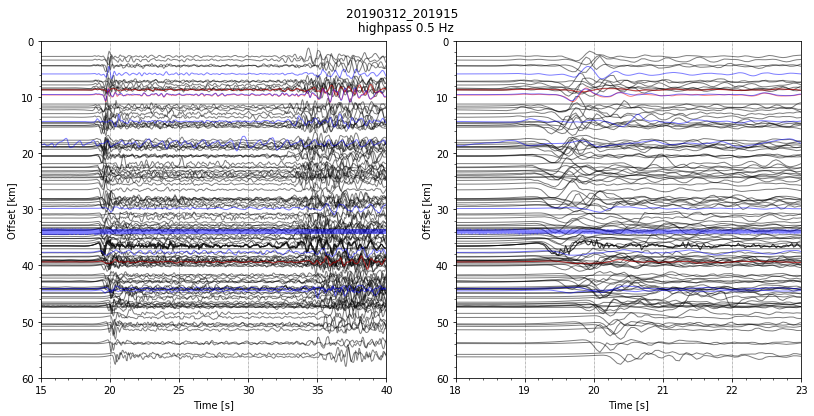

In [11]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

fig = plt.figure(figsize=(12,6))

stmp = Stream()
st_z = Stream()

st_cwb = Stream()
st_bats = Stream()
stmp = st_all.select(component="Z").copy()


#fmax, fmin = 20, 3
#stmp.filter('bandpass',freqmax=fmax,freqmin=fmin, corners=2, zerophase = True) 
#title= ('%s \n bp %s ~ %s Hz')%(dir_name[0],fmax, fmin)
fmax, fmin = 20, 0.5
stmp.filter('highpass',freq=fmin, corners=2, zerophase = True) 
title= ('%s \n highpass %s Hz')%(dir_name[0], fmin)
fname='section_filt_hp_%s_hz_z.png'%(fmin)

stmp.trim(starttime, starttime+60)

st_z += stmp.select(network='FM').copy()
st_cwb += stmp.select(network='CWB').copy()
st_bats += stmp.select(network='TW').copy()

#st_z.plot(type='section',scale=8,recordstart=18,recordlength=5, fig=fig,orientation ='horizontal')
def plot_section(tstart,tlength):
    st_z.plot(type='section',offset_max=60000.1, offset_min=0.0 ,
              scale = 5, recordstart=tstart, recordlength=tlength, 
              fig=fig, orientation ='horizontal',color='black')
    st_bats.plot(type='section',offset_max=60000.1, offset_min=0.0 ,
                 scale= 0.1,recordstart=tstart, recordlength=tlength, 
                 fig=fig, orientation ='horizontal',color='red')
    st_cwb.plot(type='section',offset_max=60000.1, offset_min=0.0 ,
                scale= 0.3, recordstart=tstart,recordlength=tlength, 
                fig=fig, orientation ='horizontal', color='blue')
    plt.gca().invert_yaxis()

plt.subplot(1,2,1)    
plot_section(15,25)

plt.subplot(1,2,2)
plot_section(18,5)

plt.suptitle(title)
plt.savefig(fname, dpi=300)
plt.show()

#ax = fig.axes[0]
#transform = blended_transform_factory(ax.transData, ax.transAxes)
#for tr in st_z:
#    ax.text(tr.stats.distance / 1e3, 1.0, tr.stats.station, rotation=270,
#            va="bottom", ha="center", transform=transform, zorder=10)



In [4]:
# for s - T comp
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

fig = plt.figure(figsize=(12,6))

stmp = Stream()
st_z = Stream()

st_cwb = Stream()
st_bats = Stream()
stmp = st_all.select(component="T").copy()


fmax, fmin = 1, 0.5
stmp.filter('bandpass',freqmax=fmax,freqmin=fmin, corners=2, zerophase = True)   
stmp.trim(starttime, starttime+60)

st_z += stmp.select(network='FM').copy()
st_cwb += stmp.select(network='CWB').copy()
st_bats += stmp.select(network='TW').copy()

#st_z.plot(type='section',scale=8,recordstart=18,recordlength=5, fig=fig,orientation ='horizontal')
def plot_section(tstart,tlength):
    st_z.plot(type='section',offset_max=60000.1, offset_min=0.0 ,
              scale = 5, recordstart=tstart, recordlength=tlength, 
              fig=fig, orientation ='horizontal',color='black')
    st_bats.plot(type='section',offset_max=60000.1, offset_min=0.0 ,
                 scale= 0.1,recordstart=tstart, recordlength=tlength, 
                 fig=fig, orientation ='horizontal',color='red')
    st_cwb.plot(type='section',offset_max=60000.1, offset_min=0.0 ,
                scale= 0.3, recordstart=tstart,recordlength=tlength, 
                fig=fig, orientation ='horizontal', color='blue')
    plt.gca().invert_yaxis()

plt.subplot(1,2,1)    
plot_section(15,30)

plt.subplot(1,2,2)
plot_section(30,10)

plt.suptitle(('%s \n bp %s ~ %s Hz, T comp.')%(dir_name[0],fmax, fmin), fontsize=14)


plt.savefig('section_filt_%s_%s_hz_t.png'%(fmax,fmin), dpi=300)
plt.show()

#ax = fig.axes[0]
#transform = blended_transform_factory(ax.transData, ax.transAxes)
#for tr in st_z:
#    ax.text(tr.stats.distance / 1e3, 1.0, tr.stats.station, rotation=270,
#            va="bottom", ha="center", transform=transform, zorder=10)



NameError: name 'Stream' is not defined

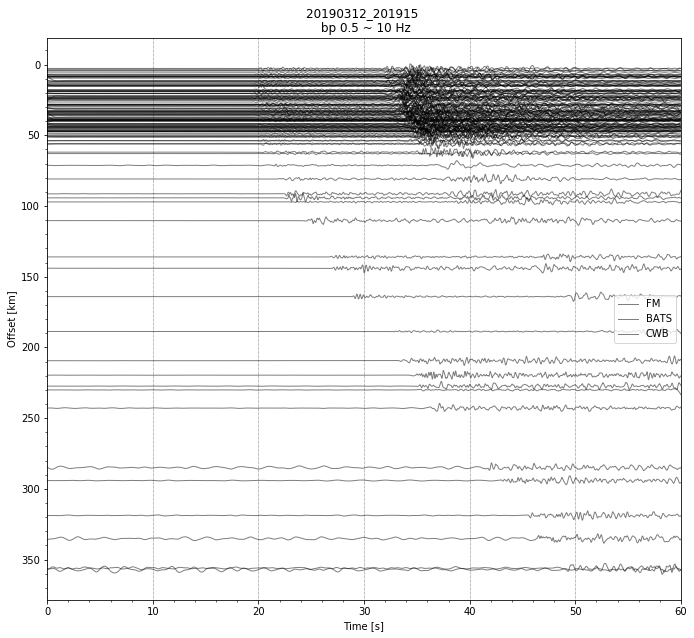

In [8]:
#st_bats.plot(type='section')
#st_cwb.plot(type='section')
#st_z.plot(type='section')
fig = plt.figure(figsize=(10,10))
stmp.plot(type='section',scale=2, fig=fig,orientation ='horizontal')

plt.gca().invert_yaxis()
plt.title(('%s \n bp %s ~ %s Hz')%(dir_name[0],fmin, fmax))
plt.legend(labels=['FM','BATS','CWB'])
#plt.savefig('section_filt_%s_%s_hz_z.png'%(fmax,fmin), dpi=300)
plt.show()


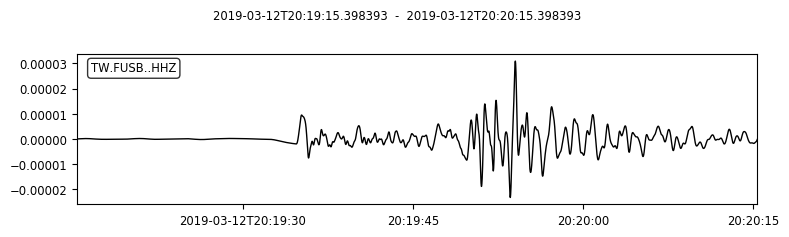

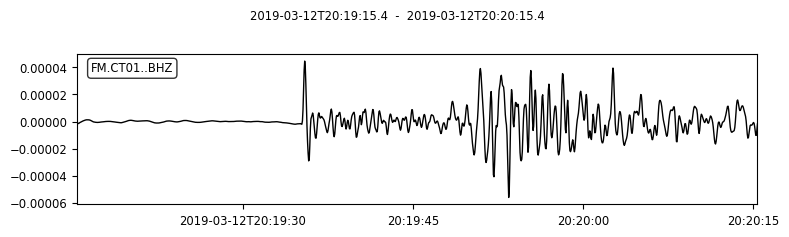

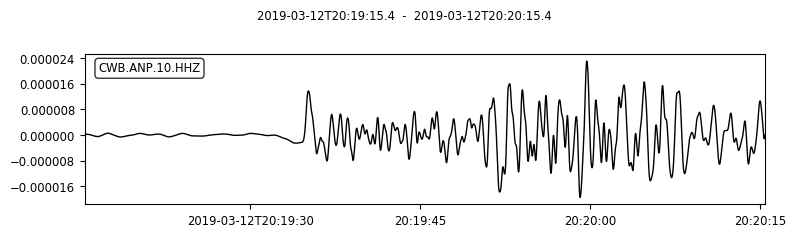

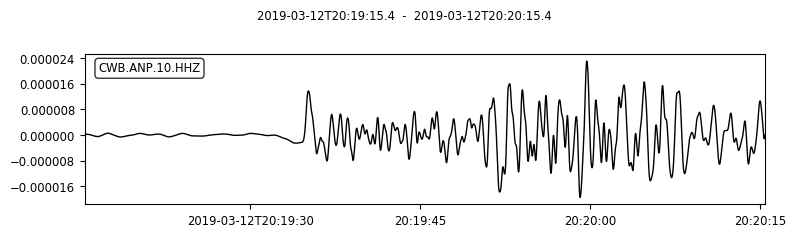

In [16]:
st_bats[0].plot()
st_z[0].plot()
st_cwb[0].plot()

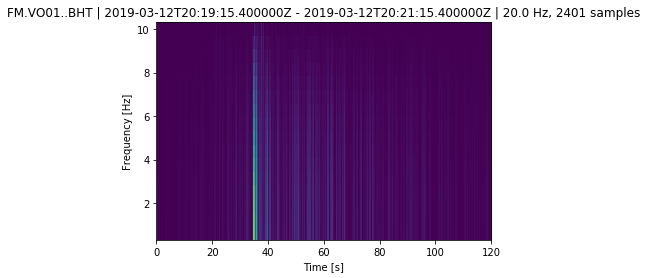

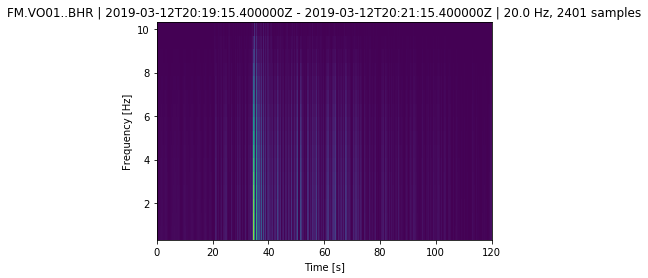

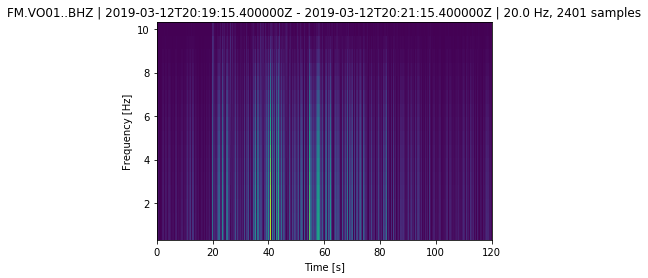

In [10]:
#plot spectrogram

st_one = Stream()
st_one += st_ori.select(station='VO01').copy()
st_one.spectrogram()#outfile='VO01_spectrum.png')
st_one.plot()#outfile='VO01_waveform.png')

D:\anaconda\lib\site-packages\obspy\signal\filter.py:67: UserWarning: Selected high corner frequency (10) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


0.353614276449


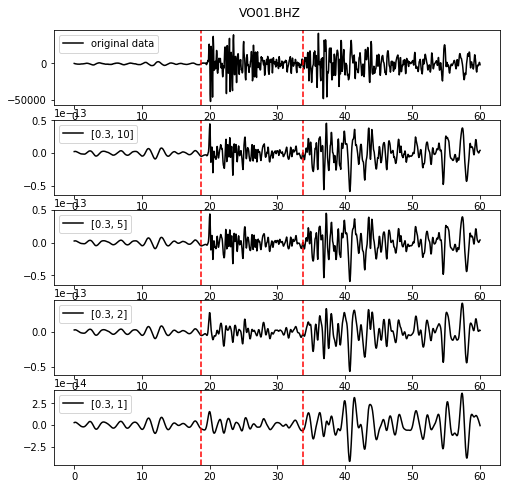

In [7]:
# test for frequency
import matplotlib.pyplot as plt
from obspy import read, Trace, Stream, UTCDateTime
from obspy.io.sac.sacpz import attach_paz
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees, degrees2kilometers

st_ori = Stream()
st = read('20190312_201915/FM.VO01..BHZ.SAC')
st_ori = st.copy()
starttime = UTCDateTime(day[1]+time[1])

paz_sts2 = {'poles': dict_station['VO01'].stats.paz['poles'],
             'zeros': dict_station['VO01'].stats.paz['zeros'], 
              'gain': dict_station['VO01'].stats.paz['gain'],
            'sensitivity':3e+8}
st.simulate(paz_remove=paz_sts2)
st.detrend('linear')


freq1 = [0.5, 2]
def st_filt(freq,st_ori):
    st_tmp = st.copy()
    st_tmp.filter('bandpass',freqmin = freq[0], freqmax = freq[1], corners=2, zerophase = True)
    st_ori += st_tmp.copy()
    return st_tmp
freq_all = ['original data',[0.3, 10],[0.3, 5],[0.3,2],[0.3,1]]
for i in range(len(freq_all)):
    if (i == 0): continue
    st_bp = st_filt(freq_all[i], st_ori)

#st_bp3 = st_filt(freq3)


#######
model = TauPyModel(model='prem')

epi_dis = locations2degrees(st[0].stats.sac.stla, st[0].stats.sac.stlo, lat[1],lon[1])
print(epi_dis)
arr_time = model.get_travel_times(source_depth_in_km=dep[1],
                                distance_in_degree=epi_dis,
                                phase_list=['p','s'])
tp, ts=arr_time[0].time, arr_time[1].time

#########

st_ori.trim(starttime=starttime, endtime=starttime+60)
#########
fig, axs = plt.subplots(figsize=(8,8),nrows=st_ori.count()) 
for ax, tr_zne, freq_lab  in zip(axs, st_ori, freq_all):
    ax.plot(tr_zne.times(), tr_zne.data, color='k', linestyle='-',
            label=freq_lab)
    #ax.set_ylim([ymin,ymax])
    ax.axvline(x=tp,color='r',linestyle='--')
    ax.axvline(x=ts,color='r',linestyle='--')
    ax.legend(loc='upper left')
    
plt.suptitle('%s.%s'%(tr_zne.stats.station,tr_zne.stats.channel),y=0.92)
plt.savefig('filter_test.png',dpi=300, bbox_inches='tight')
plt.show()

3

39361.722631887555 223.5181056437627 43.405329274177


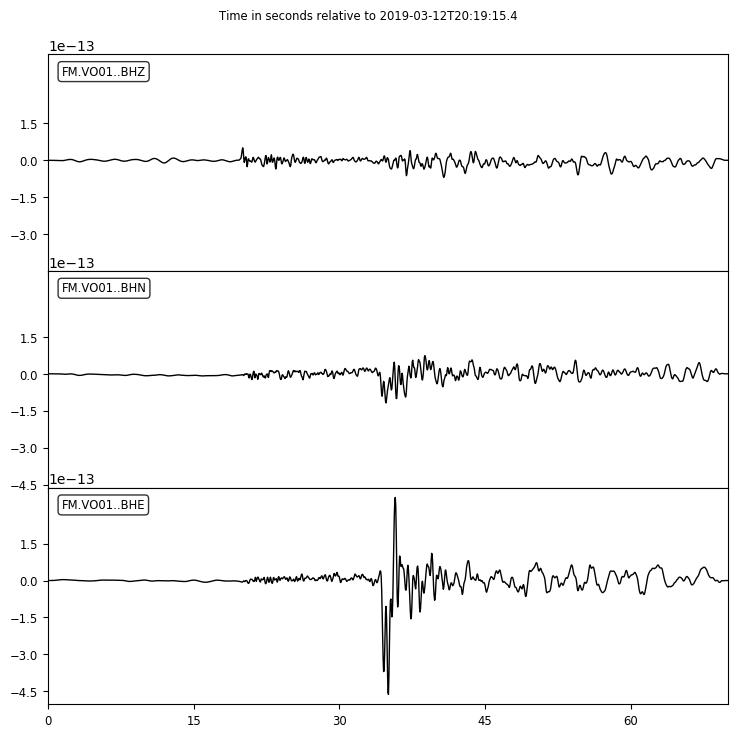

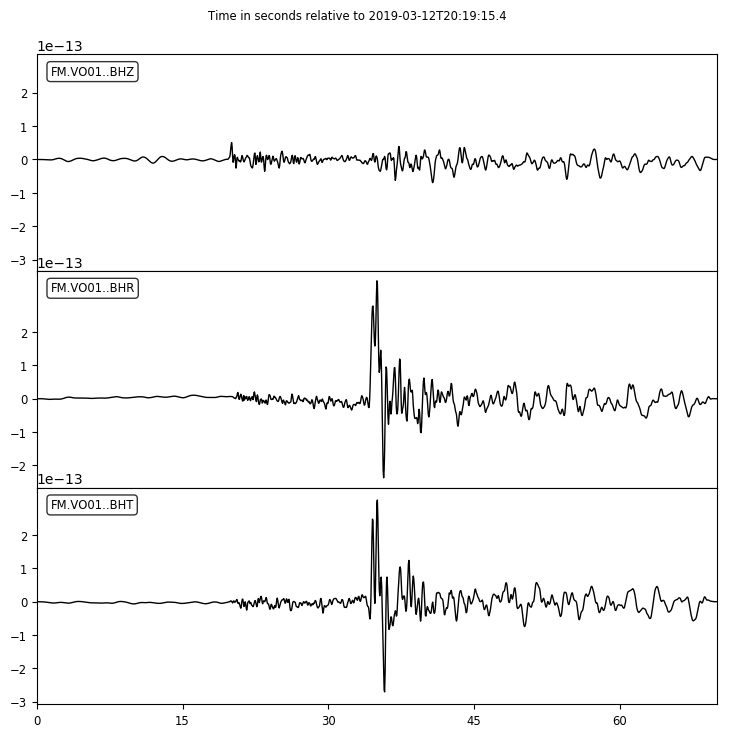

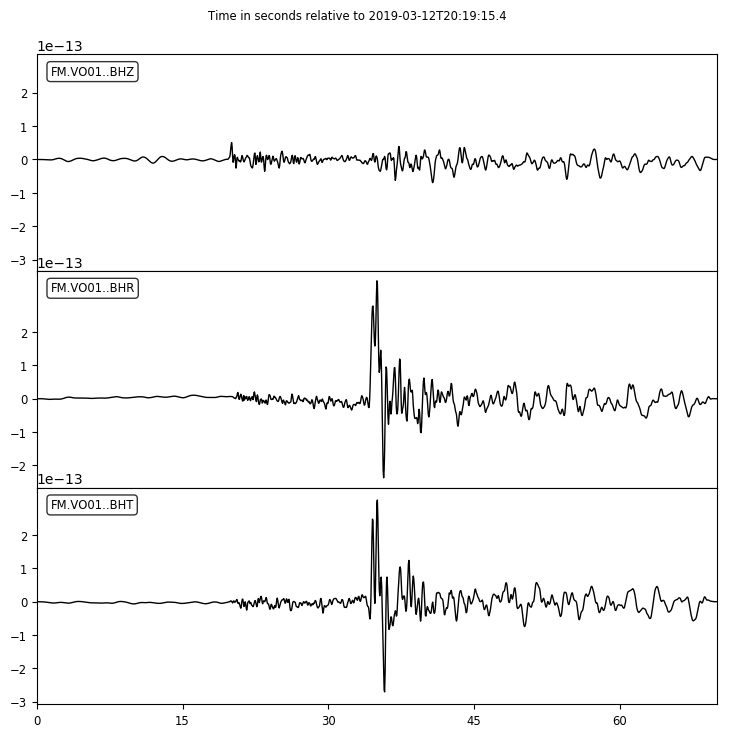

In [10]:
# test for rotate

from obspy.geodetics.base import gps2dist_azimuth
from obspy.io.sac.sacpz import attach_paz

starttime = UTCDateTime(day[1]+time[1])


epi_dis = locations2degrees(sac.stla, sac.stlo, lat[1],lon[1])
dis_m , az, baz = gps2dist_azimuth(lat[1],lon[1],sac.stla, sac.stlo)
print(dis_m , az, baz)

st_enz = read('20190312_201915/FM.VO01..BH*.SAC')
st_enz.trim(starttime, starttime+70)

st_rtz = st_enz.copy()
st_rtz.rotate(method='NE->RT', back_azimuth=baz)

st_enz_pz = st_enz.copy()
# pole zeros
tr = st_enz_pz[0]
attach_paz(tr, 'PZs/SAC_PZs_FM_VO01_BHZ__2018.001.00.00.00.0000_2599.365.23.59.59.99999')
paz_sts2 = {
    'poles': tr.stats.paz['poles'],
    'zeros':tr.stats.paz['zeros'],
    'gain': tr.stats.paz['gain'],
    'sensitivity':3e+8}
st_enz_pz.simulate(paz_remove=paz_sts2)


st_rtz_pz = st_enz_pz.copy()
st_rtz_pz.rotate(method='NE->RT', back_azimuth=baz)

st_enz.plot(type='relative',outfile='origin_enz.png')
st_rtz.plot(type='relative',outfile='rot_rtz.png')

st_enz_pz.plot(type='relative') #,outfile='remove_pz.png'
st_rtz_pz.plot(type='relative')#,outfile='rot_rtz_pz.png')

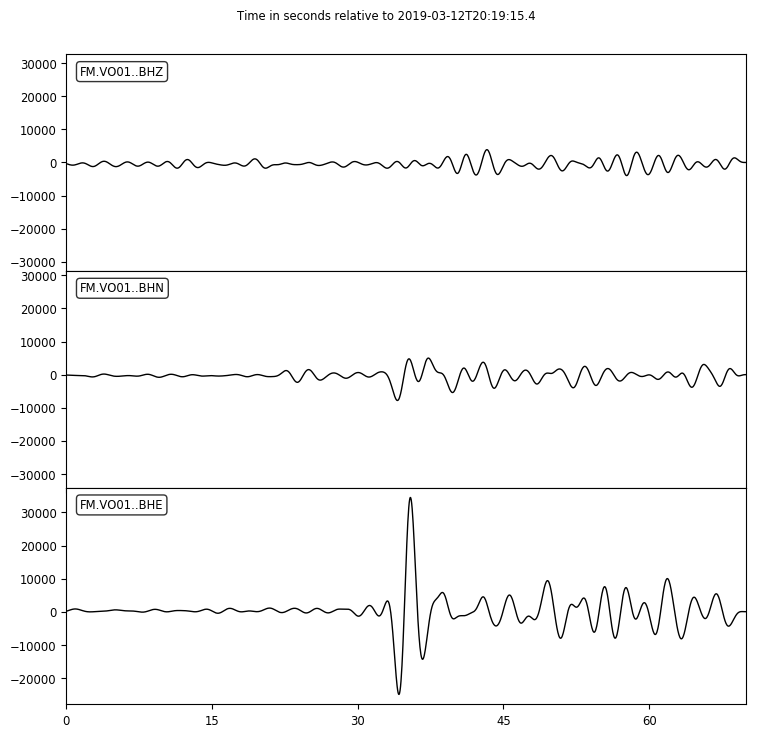

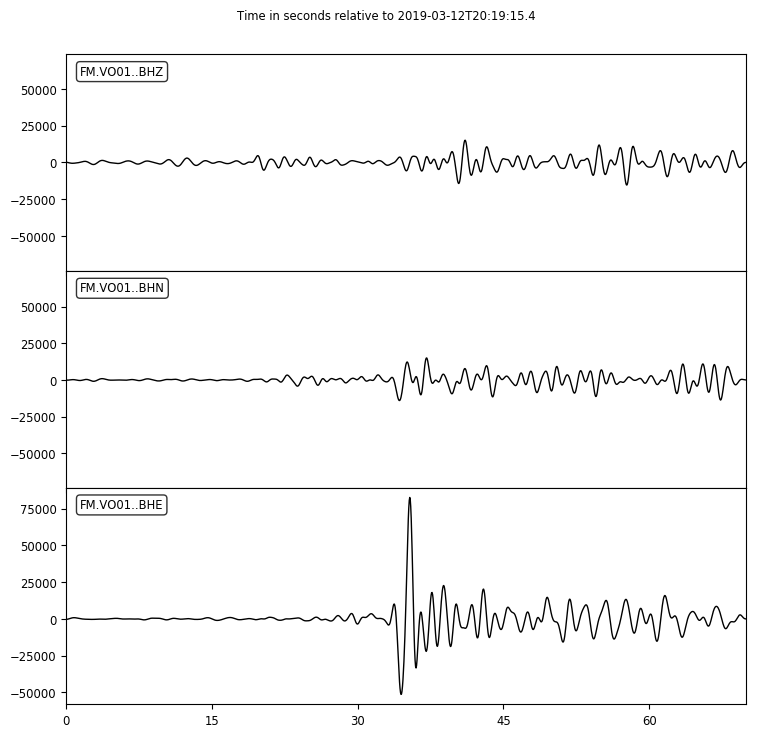

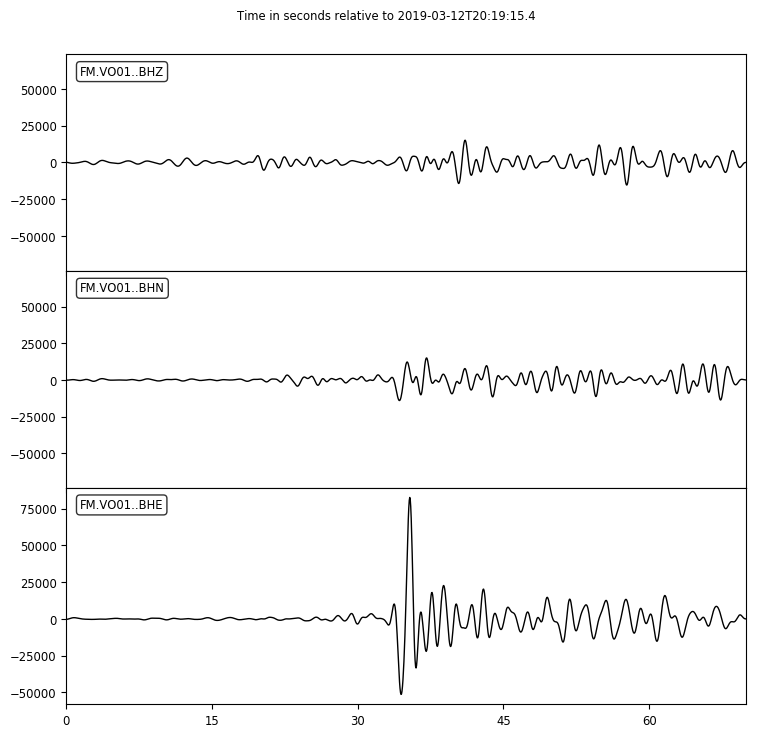

In [8]:
# filter
st_lp = st_enz.copy()
st_lp_1 = st_enz.copy()
st_lp.filter('lowpass',freq=0.5, zerophase = True)
st_lp_1.filter('bandpass',freqmax=1, freqmin=0.1, zerophase = True)
st_lp.plot(type='relative')#,outfile='filt_0.5.png')
st_lp_1.plot(type='relative')#,outfile='filt_1_0.1.png')

In [1]:
from obspy.geodetics.base import gps2dist_azimuth
from obspy.io.sac.sacpz import attach_paz

starttime = UTCDateTime(day[1]+time[1])


epi_dis = locations2degrees(sac.stla, sac.stlo, lat[1],lon[1])
dis_m , az, baz = gps2dist_azimuth(lat[1],lon[1],sac.stla, sac.stlo)
print(dis_m , az, baz)

st_enz = read('20190312_201915/FM.VO01..BH*.SAC')
st_enz.trim(starttime, starttime+70)

st_rtz = st_enz.copy()
st_rtz.rotate(method='NE->RT', back_azimuth=baz)

st_enz_pz = st_enz.copy()
# pole zeros

#attach_paz(tr, 'PZs/SAC_PZs_FM_VO01_BHZ__2018.001.00.00.00.0000_2599.365.23.59.59.99999')



paz_sts2 = {
    'poles': dict_station['VO01'].stats.paz['poles'],
    'zeros': dict_station['VO01'].stats.paz['zeros'],
    'gain': dict_station['VO01'].stats.paz['gain'],
    'sensitivity':3e+8}
st_enz_pz.simulate(paz_remove=paz_sts2)


st_rtz_pz = st_enz_pz.copy()
st_rtz_pz.rotate(method='NE->RT', back_azimuth=baz)




st_enz.plot(type='relative')#,outfile='origin_enz.png')
#st_rtz.plot(type='relative',outfile='rot_rtz.png')

st_enz_pz.plot(type='relative') #,outfile='remove_pz.png'
#st_rtz_pz.plot(type='relative')#,outfile='rot_rtz_pz.png')

NameError: name 'UTCDateTime' is not defined

In [11]:
# Reading and preprocessing the Formosa Array Data 
from obspy.io.sac import SACTrace
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees, degrees2kilometers
import glob
import os
from obspy.geodetics.base import gps2dist_azimuth
from obspy.io.sac.sacpz import attach_paz


st_all = Stream()

model = TauPyModel(model='prem')
#for i in range(len(day)):
#for i in np.arange(18):
num=[1]
for i in num:
    starttime = UTCDateTime(day[i]+time[i])
    dir = starttime.strftime('%Y%m%d_%H%M%S')
    
    print(dir, starttime)
    #sac_bh = glob.glob('%s/*VO01..BHZ.SAC'%(dir))
    sac_bh = glob.glob('%s/*BHZ.SAC'%(dir))
    
    #os.mkdir('p/%s'%(dir))
    #os.mkdir('s/%s'%(dir))
    
    for sacfile in sac_bh:
        st_ori = Stream()
        sta = sacfile.split('.')[1]
        if (sta == 'CT15' or sta=='WU18'):
            continue
        
        st = read('%s/*%s*BH*.SAC'%(dir,sta))
        print(st)
        st.trim(starttime=starttime-250, endtime=starttime+250)
        
        epi_dis = locations2degrees(lat[i],lon[i],
                                    st[0].stats.sac.stla, st[0].stats.sac.stlo)
        dis_m , az, baz = gps2dist_azimuth(lat[i],lon[i],
                                           st[0].stats.sac.stla, st[0].stats.sac.stlo)
        #print(dis_m , az, baz)
        paz_sts2 = {'poles': dict_station[sta].stats.paz['poles'],
                    'zeros': dict_station[sta].stats.paz['zeros'], 
                    'gain': dict_station[sta].stats.paz['gain'],
                    'sensitivity' : dict_station[sta].stats.paz['sensitivity'] }
#                    'sensitivity':3e+8}
        st.simulate(paz_remove=paz_sts2)
        st.filter('bandpass', freqmax=10, freqmin=0.1, corners=2, zerophase = True)       
        st.rotate(method='NE->RT', back_azimuth=baz)        
        #st.detrend(type='demean')
        st.trim(starttime=starttime, endtime=starttime+120)
        st_ori += st.copy()
        
        #st.plot()
        for tr in st :
            #print(tr)
            #tr.plot()
            sac = SACTrace.from_obspy_trace(tr)
            # modify loop
            epi_dis = locations2degrees(sac.stla, sac.stlo, lat[i],lon[i])
            arr_time = model.get_travel_times(source_depth_in_km=dep[i],
                                              distance_in_degree=epi_dis,
                                              phase_list=['p','s'])
            tr.stats.sac.az = az
            tr.stats.distance = dis_m
            st_all += tr
            sac.evla = lat[i]
            sac.evlo = lon[i]
            sac.evdp = dep[i]
            sac.stdp = 0.
            sac.stel = 0.
            sac.o = starttime
            sac.iztype = 'io' 
            sac.lcalda = True 
            
            for phase in ['p', 's']:
                if (phase == 'p'):
                    sac.t0 = arr_time[0].time
                    sac.t2 = arr_time[0].time
                    sac.kt0 = arr_time[0].name
                elif (phase == 's') :
                    sac.t0 = arr_time[1].time
                    sac.t2 = arr_time[1].time
                    sac.kt0 = arr_time[1].name
                #name = ('%s/%s.%s.%s.SAC')%(dir, tr.stats.network, tr.stats.station, tr.stats.channel)
                name = ('%s.%s.%s.SAC')%(tr.stats.network, tr.stats.station, tr.stats.channel)
                sac.write('Processed_20190312/%s.mark'%(name))
                
           
            #sac.write('p/%s.%s.%s.mark'%(tr.stats.network,tr.stats.station,tr.stats.channel))
    print('ok')
    #os.chdir('../')


20190312_201915 2019-03-12T20:19:15.390000Z
3 Trace(s) in Stream:
FM.KM06..BHE | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.KM06..BHN | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.KM06..BHZ | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
3 Trace(s) in Stream:
FM.PN02..BHE | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.PN02..BHN | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.PN02..BHZ | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
3 Trace(s) in Stream:
FM.VO09..BHE | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.VO09..BHN | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.VO09..BHZ | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
3 Trace(

/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):
/home/userlibs/anaconda3/lib/python3.6/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (10) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


3 Trace(s) in Stream:
FM.PN01..BHE | 2019-03-12T20:14:15.021860Z - 2019-03-12T20:49:15.021860Z | 20.0 Hz, 42001 samples
FM.PN01..BHN | 2019-03-12T20:14:15.021860Z - 2019-03-12T20:49:15.021860Z | 20.0 Hz, 42001 samples
FM.PN01..BHZ | 2019-03-12T20:14:15.021860Z - 2019-03-12T20:49:15.021860Z | 20.0 Hz, 42001 samples
3 Trace(s) in Stream:
FM.KM21..BHE | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.KM21..BHN | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.KM21..BHZ | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
3 Trace(s) in Stream:
FM.KM16..BHE | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.KM16..BHN | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
FM.KM16..BHZ | 2019-03-12T20:14:15.000000Z - 2019-03-12T20:49:15.000000Z | 20.0 Hz, 42001 samples
3 Trace(s) in Stream:
FM.PN11..BHE | 2019-03-12T20:1